Name: Sean Noonan

Student ID: 23300159

### Clustering and Manifold Learning

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

#### Load the dataset

In [244]:
df = pd.read_csv("./bank.csv")
print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


### B. Exploratory Data Analysis and Data Preparation

In [245]:
df.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [246]:
df.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

#### Create a pipeline

###### I am copying preprocessing steps from my etivity1. Please refer to it to understand the transformations added here

In [247]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.creation import CyclicalFeatures

In [248]:
def replace_values_ed(X):
    # Handle missing values in 'education' column if necessary
     # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        raise ValueError("Input X must be a pandas DataFrame.")  
        print("Not a dataframe")
    
    # Define the scale_mapper
    scale_mapper = {
        np.nan: 0,
        "primary": 1,
        "secondary": 2,
        "tertiary": 3,
    }
    
    # Replace values in 'education' column using the scale_mapper
    X['education'] = X['education'].replace(scale_mapper)
    
    return X

def replace_values_month(X):
    # Handle missing values in 'education' column if necessary
     # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        raise ValueError("Input X must be a pandas DataFrame.")  
        print("Not a dataframe")
    
    mapper = {
        "jan": 0,
        "feb": 1,
        "mar": 2,
        "apr": 3,
        "may": 4,
        "jun": 5,
        "jul": 6,
        "aug": 7,
        "sep": 8,
        "oct": 9,
        "nov": 10,
        "dec": 11,
    }

    X['month'] = X['month'].replace(mapper)
    
    return X

# Define a custom function to apply pd.get_dummies() to specified columns
def get_dummies_nan(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)# Convert to DataFrame if not already
        print("Not a dataframe")
    X_encoded = pd.get_dummies(X, dummy_na=True, drop_first=True) # One-hot encode categorical columns df[categorical_columns]
    return X_encoded

# Define a custom function to apply pd.get_dummies() to specified columns
def get_dummies_except(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)# Convert to DataFrame if not already
        print("Not a dataframe")
    X_encoded = pd.get_dummies(X, drop_first=True)  # One-hot encode categorical columns
    return X_encoded

# Define the log function
def log_transform(X):
    return np.log(X + abs(min(X)) + 1)

CyclicalFeatures(variables=None, drop_original=False)

cyclical_features = ['month','day']
cyclical_transformer = Pipeline(
    steps=[
        ("replace_values", FunctionTransformer(func=replace_values_month)),
        ("cyclical_values", CyclicalFeatures(variables=None, drop_original=True))
    ]
)

education_transformer = Pipeline(
    steps=[
        ("replace_values", FunctionTransformer(func=replace_values_ed))
    ]
)

cat_nans = ['job', 'contact','poutcome']
catnans_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='constant', fill_value='other')),
           #("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("encoder", FunctionTransformer(func=get_dummies_nan)),
           ("scaler", StandardScaler(with_mean=False))]
)

# Note I am leaving out the 'subscribed' field to find pure clusters
cat_features = [col for col in df.columns if col not in ['job', 'contact', 'education','balance','month','day','pdays','age','duration', 'subscribed']]
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='constant', fill_value='other')),
        #("encoder", OneHotEncoder(handle_unknown="ignore"))
        ("encoder", FunctionTransformer(func=get_dummies_except))
    ]
)

balance_transformer = Pipeline(
    steps=[
        (("scaler", RobustScaler())),
        ("encoder", FunctionTransformer(func=log_transform))
    ]
)

scaler_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy='constant', fill_value=0)),
        (("scaler", StandardScaler()))
    ]
)

preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("ed", education_transformer,['education']),
        ("balance", balance_transformer, ['balance']),
        ("month", month_transformer, ['month']),
        ("cyclical", cyclical_transformer, cyclical_features),
        ("catnans", catnans_transformer, cat_nans),
        ("cat", categorical_transformer, cat_features),
        ("scale", scaler_transformer, ['pdays','age','duration'])
    ]
)

I will run eperiments for case where:

1. Subscribed is included and case where excluded.
2. Case with and without cyclical features.

Lets look at the transformed data

In [249]:
# Fit and transform the data
transformed_data = preprocess_pipeline.fit_transform(df)

# Convert the transformed data into a DataFrame
transformed_df = pd.DataFrame(transformed_data)

if not isinstance(transformed_df, pd.DataFrame):
    print("Not a dataframe")

# Display the transformed DataFrame
transformed_df

Not a dataframe
Not a dataframe


C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3261583520.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['education'] = X['education'].replace(scale_mapper)
C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3908607381.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['month'] = X['month'].replace(mapper)


0         1    2         3         4         5         6         7   \
0     3.0  0.668238  3.0  0.989821 -0.142315  0.201299  0.979530  0.000000   
1     2.0  0.768220  3.0  0.989821 -0.142315  0.201299  0.979530  0.000000   
2     2.0  0.873966  3.0  0.989821 -0.142315  0.201299  0.979530  0.000000   
3     2.0  0.670367  3.0  0.989821 -0.142315  0.201299  0.979530  2.808291   
4     2.0  0.864961  3.0  0.989821 -0.142315  0.201299  0.979530  0.000000   
...   ...       ...  ...       ...       ...       ...       ...       ...   
1995  0.0  1.283472  8.0 -0.989821 -0.142315 -0.101168 -0.994869  0.000000   
1996  2.0  0.569369  8.0 -0.989821 -0.142315 -0.101168 -0.994869  0.000000   
1997  1.0  0.907800  8.0 -0.989821 -0.142315 -0.299363 -0.954139  0.000000   
1998  1.0  1.545186  8.0 -0.989821 -0.142315 -0.790776 -0.612106  0.000000   
1999  2.0  1.810978  8.0 -0.989821 -0.142315 -0.968077 -0.250653  0.000000   

            8    9   ...   57   58   59   60   61   62   63        64  \
0     0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.280107   
1     0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -0.264923   
2     0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.539807   
3     0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.532215   
4     0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.056049   
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
1995  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.282224   
1996  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.282224   
1997  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.282224   
1998  0.000000  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.282224   
1999  6.742956  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0 -1.282224   

            65        66  
0    -0.726135  3.002139  
1    -0.191229 -0.266456  
2     1.337075 -0.749522  
3     0.420092 -0.081356  
4     0.954999  0.844144  
...        ...       ...  
1995 -1.643117  0.157920  
1996 -1.031796  4.704156  
1997  3.018209 -0.275485  
1998  0.343677 -0.483158  
1999 -0.114814 -0.379322  

[2000 rows x 67 columns]

In [250]:
# Fit and transform the data
#transformed_data = preprocess_pipeline.fit_transform(df)

#transformed_data_dense=transformed_data.toarray()

# Convert the transformed data into a DataFrame
#transformed_df = pd.DataFrame(transformed_data_dense)

# Display the transformed DataFrame
#transformed_df

In [251]:
# Plot
#transformed_df.hist(bins=50)

### C. Scatterplot Function (to be used below for visualising a clustering)

Skip this section when you read the notebook for the first time.

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [252]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

### D. K-Means Clustering

In [253]:
k = 3

pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])

Next, we fit the pipeline on the dataset to train a clustering model.

In [254]:
clustering_model = pipe.fit(df)

C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3261583520.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['education'] = X['education'].replace(scale_mapper)
C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3908607381.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['month'] = X['month'].replace(mapper)


Not a dataframe
Not a dataframe


In [255]:
# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model['preprocess'].transform(df)

#preprocessed_data_dense=preprocessed_data.toarray()
print(preprocessed_data)

Not a dataframe
Not a dataframe
[[ 3.          0.66823798  3.         ... -0.28010681 -0.72613526
   3.00213905]
 [ 2.          0.76821994  3.         ... -0.26492322 -0.19122899
  -0.26645596]
 [ 2.          0.87396611  3.         ...  0.53980687  1.33707463
  -0.74952179]
 ...
 [ 1.          0.90780018  8.         ... -1.28222352  3.01820861
  -0.27548522]
 [ 1.          1.54518579  8.         ... -1.28222352  0.34367728
  -0.48315839]
 [ 2.          1.81097763  8.         ... -1.28222352 -0.11481381
  -0.37932181]]


C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3261583520.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['education'] = X['education'].replace(scale_mapper)
C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3908607381.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['month'] = X['month'].replace(mapper)


### E. Apply a manifold-learning technique to project the data set to a 2D space

https://scikit-learn.org/stable/modules/manifold.html

Append the cluster centers to the preprocessed dataset.

In [256]:
data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

#### E1. Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [257]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
print("transformation complete")

transformation complete


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

In [258]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

We can see the split between 3 groups.

#### E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space

Project both the data and the k-Means cluster centers to 2D.

In [259]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


Plot the transformed examples and the centers. Use the cluster assignment to colour the examples.

In [260]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

### F. Cluster Analysis

#### Add the cluster labels as an extra column in the original dataframe

In [261]:
df_tran=df

In [262]:
df_tran['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)

In [263]:
df_tran.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  cluster  
0         no        0  
1         no        0  
2         no        0  
3         no        0  
4         no        0

In [264]:
df_tran.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  cluster  
1995        yes        1  
1996        yes        1  
1997        yes        1  
1998        yes        1  
1999        yes        1

#### Compute the mean value of each attribute for each cluster

In [265]:
df_tran.groupby('cluster').describe()

age                                                     balance  \
         count       mean        std   min   25%   50%   75%   max   count   
cluster                                                                      
0        679.0  41.047128  13.456391  18.0  31.0  37.0  49.0  86.0   680.0   
1        625.0  43.024000  14.780154  19.0  32.0  39.0  53.0  93.0   628.0   
2        684.0  41.292398   9.461142  23.0  33.0  39.0  49.0  72.0   692.0   

                      ...   pdays        previous                           \
                mean  ...     75%    max    count      mean       std  min   
cluster               ...                                                    
0        1661.083824  ...  182.00  595.0    680.0  1.798529  2.543118  0.0   
1        1682.597134  ...  187.00  854.0    628.0  2.985669  3.812359  0.0   
2         926.472543  ...  261.25  648.0    692.0  2.926301  3.611615  0.0   

                              
         25%  50%  75%   max  
cluster                       
0        0.0  1.0  3.0  19.0  
1        1.0  2.0  4.0  55.0  
2        1.0  2.0  3.0  51.0  

[3 rows x 56 columns]

### Sum of Squared Distances and Elbow Method:

In [266]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

# Function to calculate Sum of Squared Distances (SSD) for different values of k
def calculate_ssd(X, k_max):
    ssd = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
        kmeans.fit(X)
        ssd.append(kmeans.inertia_)
    return ssd

# Calculate SSD for different values of k
k_max = 20  # Maximum number of clusters to consider
ssd = calculate_ssd(transformed_df, k_max)

# Plot SSD against the number of clusters (k) and identify the "elbow" point
plt.plot(range(1, k_max + 1), ssd, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method')
plt.xticks(range(1, k_max + 1))
plt.grid(True)
plt.show()

# Identify the "elbow" point to determine the optimal value of k
# You can visually inspect the plot to find the "elbow" point or use a more automated method



The elbow point is simply k=3. After this there is a linear decline in the sum of squares.Our guess from above was a good one!

Use the silhoutte method also

In [267]:
from sklearn.metrics import silhouette_score

# Initialize variables to store best silhouette score and corresponding value of k
best_score = -1
best_k = -1

# Iterate over different values of k
for k in range(2, 11):
    # Create and fit KMeans clustering model
    kmeans = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(transformed_df)
    
    # Calculate Silhouette Coefficient
    silhouette_avg = silhouette_score(transformed_df, kmeans.labels_)
    
    # Update best score and value of k if silhouette score is higher
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_k = k

# Print the best value of k and corresponding silhouette score
print("Best value of k:", best_k)
print("Silhouette Score:", best_score)


Best value of k: 2
Silhouette Score: 0.24503804481362582


It is suggesting a best k value of 2. This makes sense as this is a binary problem. The silhouette coefficient measure how comparable points from the same cluster are.

In [268]:
# Update your pipeline with the optimal value of k
optimal_k = 2  # Example value for the optimal number of clusters
pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipeline), 
    ('kMeans', KMeans(n_clusters=optimal_k, n_init=10, max_iter=300, random_state=42))
])

# Fit the pipeline with the data
clustering_model_opt = pipe.fit(df)

Not a dataframe
Not a dataframe


C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3261583520.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['education'] = X['education'].replace(scale_mapper)
C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3908607381.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['month'] = X['month'].replace(mapper)


In [269]:
# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model_opt['preprocess'].transform(df)

Not a dataframe
Not a dataframe


C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3261583520.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['education'] = X['education'].replace(scale_mapper)
C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3908607381.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['month'] = X['month'].replace(mapper)


In [270]:
data_and_centers = np.r_[preprocessed_data,clustering_model_opt['kMeans'].cluster_centers_]

In [271]:
XYcoordinatesm = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


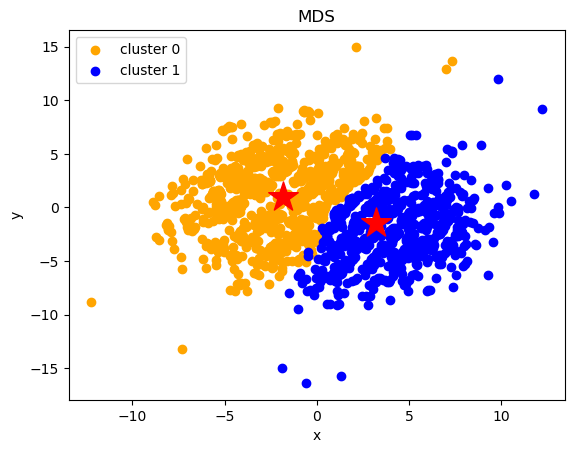

In [272]:
clustering_scatterplot(points=XYcoordinatesm[:-optimal_k,:], 
                       labels=clustering_model_opt['kMeans'].labels_, 
                       centers=XYcoordinatesm[-optimal_k:,:], 
                       title='MDS')

We can clearly see the two clusters.

MDS: MDS seeks to preserve the pairwise distances between data points in the high-dimensional space when projecting them onto a lower-dimensional space. It aims to find a representation where similar data points in the original space remain close to each other in the lower-dimensional space.

In [273]:
XYcoordinatest = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


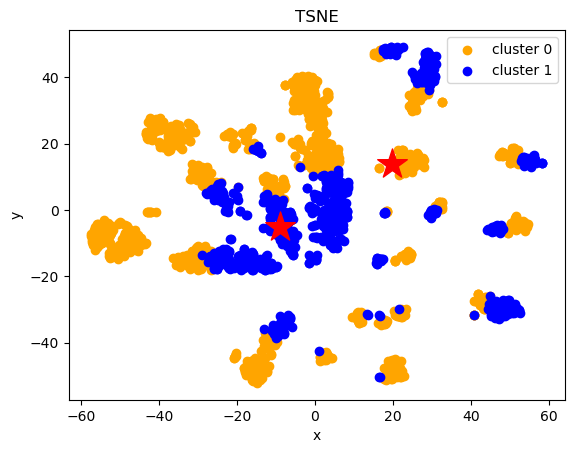

In [274]:
clustering_scatterplot(points=XYcoordinatest[:-optimal_k,:], 
                       labels=clustering_model_opt['kMeans'].labels_,
                       centers=XYcoordinatest[-optimal_k:,:], 
                       title='TSNE')

t-SNE: t-SNE is based on probability distributions and aims to learn a mapping from the high-dimensional space to a lower-dimensional space such that similar data points are modeled with similar probability distributions. It focuses on preserving the local structure of the data, aiming to keep nearby points close and distant points far apart.

We can see the two clusters however they are not as separated as in MDS. We have orange points in the middle of blue etc.

In [277]:
df_tran_opt=df
df_tran_opt['cluster'] = pd.Series(clustering_model_opt['kMeans'].labels_, index=df.index)

In [281]:
df_tran_opt.head()

age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  cluster  
0         no        0  
1         no        0  
2         no        0  
3         no        0  
4         no        0

Good to see cluster group matching subscribed. Cluster 0 is not subscribed.

In [283]:
# Count the number of records with the same values in 'field1' and 'field2'
num_records_neg = df[(df['subscribed'] == 'no') & (df['cluster'] == 0)].shape[0]
num_records_pos = df[(df['subscribed'] == 'yes') & (df['cluster'] == 1)].shape[0]

print("Number of records with the same values in 'subscribed' and 'cluster':", num_records_neg)
print("Number of records with the same values in 'subscribed' and 'cluster':", num_records_pos)

Number of records with the same values in 'subscribed' and 'cluster': 936
Number of records with the same values in 'subscribed' and 'cluster': 680


Out of 2000 the cluster matches subscribed 1616 times. That is 81% accuracy.

In [284]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)

In [285]:
df_tran_opt.groupby('cluster').describe()

age                                                     balance  \
          count       mean        std   min   25%   50%   75%   max   count   
cluster                                                                       
0        1247.0  41.255012  11.346396  18.0  33.0  38.0  49.0  86.0  1256.0   
1         741.0  42.591093  14.726016  19.0  31.0  38.0  53.0  93.0   744.0   

                                                                           \
                mean          std    min     25%    50%      75%      max   
cluster                                                                     
0        1252.279459  3374.885417 -980.0  139.00  448.5  1220.50  81204.0   
1        1686.107527  2649.849691 -205.0  314.75  879.5  2131.25  31472.0   

            day                                                   duration  \
          count       mean        std  min  25%   50%   75%   max    count   
cluster                                                                      
0        1256.0  13.444268  10.509116  1.0  4.0   8.0  26.0  31.0   1256.0   
1         744.0  14.538978   8.153546  1.0  8.0  14.0  21.0  31.0    744.0   

                                                                     campaign  \
               mean         std   min     25%    50%     75%     max    count   
cluster                                                                         
0        246.550159  197.563475   7.0  114.75  195.0  319.00  1823.0   1256.0   
1        368.782258  238.210864  21.0  218.75  303.0  440.75  1720.0    744.0   

                                                        pdays              \
             mean       std  min  25%  50%  75%   max   count        mean   
cluster                                                                     
0        1.952229  1.416784  1.0  1.0  1.0  2.0  11.0  1256.0  173.232484   
1        1.837366  1.310133  1.0  1.0  1.0  2.0  11.0   744.0  158.887097   

                                                     previous            \
                std  min    25%    50%    75%    max    count      mean   
cluster                                                                   
0        113.442019 -1.0  87.00  197.0  257.0  648.0   1256.0  2.321656   
1        157.598390 -1.0   1.75  148.0  186.0  854.0    744.0  2.966398   

                                             
              std  min  25%  50%  75%   max  
cluster                                      
0        3.134953  0.0  1.0  2.0  3.0  51.0  
1        3.775347  0.0  1.0  2.0  4.0  55.0

Notes: 

The mean age for both clusters is very close. This indicates that age is not that important. It is slightly higher for cluster 1. the standard deviation is higher for second cluster(subscribed). Peolpe in second cluster have a lower balance. Maybe they feel the need to set up a savings accoun tin order to save their money.

In [286]:
# Compute mode for each column
mode_values = df_tran_opt.mode()

print("Mode values for each column:")
print(mode_values)

Mode values for each column:
    age         job  marital  education default  balance housing loan  \
0  33.0  management  married  secondary      no      0.0      no   no   
1   NaN         NaN      NaN        NaN     NaN      NaN     NaN  NaN   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular  8.0   feb     200.0       1.0   -1.0       0.0  failure   
1       NaN  NaN   NaN       NaN       NaN    NaN       NaN      NaN   

  subscribed  cluster  
0         no      0.0  
1        yes      NaN  


We can see that married people are in cluster 0 and not looking to create savings account. People who have not indicated their education (NaN) are in cluster 1. As seen before 'cellular' is less likely to induce subscribing and previous oucome of failure likely indicates another failure.

Why do I have NaN for cluster 1? This would suggest that people for which there is a lot of missing data are most likely to subscribe.

#### Lets try DBSCAN

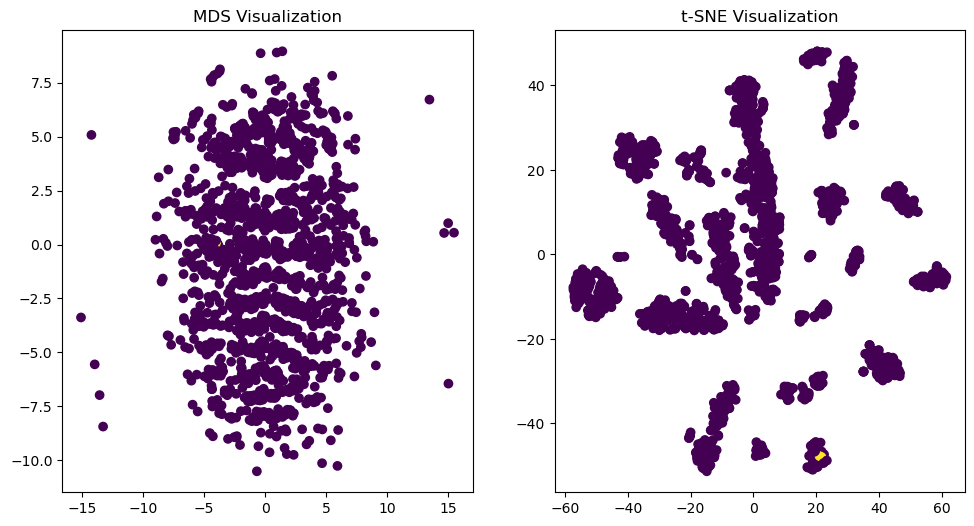

In [275]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(transformed_df)

# Apply dimensionality reduction using MDS and t-SNE
mds = manifold.MDS(n_components=2)
mds_transformed = mds.fit_transform(transformed_df)

tsne = manifold.TSNE(n_components=2)
tsne_transformed = tsne.fit_transform(transformed_df)

# Visualize the reduced-dimensional data with cluster labels
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1], c=cluster_labels, cmap='viridis')
plt.title('MDS Visualization')

plt.subplot(1, 3, 2)
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cluster_labels, cmap='viridis')
plt.title('t-SNE Visualization')

#plt.subplot(1, 3, 3)
#plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=cluster_labels, cmap='viridis')
#plt.title('Original Data with DBSCAN Clusters')

plt.show()

Similar to Kmeans splitting.

In [293]:
transformed_df

0         1    2         3         4         5         6         7   \
0     3.0  0.668238  3.0  0.989821 -0.142315  0.201299  0.979530  0.000000   
1     2.0  0.768220  3.0  0.989821 -0.142315  0.201299  0.979530  0.000000   
2     2.0  0.873966  3.0  0.989821 -0.142315  0.201299  0.979530  0.000000   
3     2.0  0.670367  3.0  0.989821 -0.142315  0.201299  0.979530  2.808291   
4     2.0  0.864961  3.0  0.989821 -0.142315  0.201299  0.979530  0.000000   
...   ...       ...  ...       ...       ...       ...       ...       ...   
1995  0.0  1.283472  8.0 -0.989821 -0.142315 -0.101168 -0.994869  0.000000   
1996  2.0  0.569369  8.0 -0.989821 -0.142315 -0.101168 -0.994869  0.000000   
1997  1.0  0.907800  8.0 -0.989821 -0.142315 -0.299363 -0.954139  0.000000   
1998  1.0  1.545186  8.0 -0.989821 -0.142315 -0.790776 -0.612106  0.000000   
1999  2.0  1.810978  8.0 -0.989821 -0.142315 -0.968077 -0.250653  0.000000   

            8    9    10   11        12   13        14        15       16  \
0     0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  2.63776   
1     0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  2.63776   
2     0.000000  0.0  0.0  0.0  3.665217  0.0  0.000000  0.000000  0.00000   
3     0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.00000   
4     0.000000  0.0  0.0  0.0  3.665217  0.0  0.000000  0.000000  0.00000   
...        ...  ...  ...  ...       ...  ...       ...       ...      ...   
1995  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  4.678007  0.00000   
1996  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.00000   
1997  0.000000  0.0  0.0  0.0  3.665217  0.0  0.000000  0.000000  0.00000   
1998  0.000000  0.0  0.0  0.0  0.000000  0.0  3.634712  0.000000  0.00000   
1999  6.742956  0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.00000   

       17   18        19        20   21   22   23   24   25   26   27   28  \
0     0.0  0.0  0.000000  0.000000  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0   
1     0.0  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0   
2     0.0  0.0  0.000000  0.000000  0.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0   
3     0.0  0.0  0.000000  0.000000  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0   
4     0.0  0.0  0.000000  0.000000  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
...   ...  ...       ...       ...  ...  ...  ...  ...  ...  ...  ...  ...   
1995  0.0  0.0  0.000000  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
1996  0.0  0.0  0.000000  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   
1997  0.0  0.0  0.000000  3.844136  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0  0.0  3.402468  0.000000  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0   
1999  0.0  0.0  0.000000  0.000000  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   

       29   30   31   32   33   34   35   36   37   38   39   40   41   42  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       43   44   45   46   47   48   49   50   51   52   53   54   55   56  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0

In [309]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'eps': [0.5, 1.0, 1.5, 2, 3, 4],
    'min_samples': [1, 5, 10, 15]
}

# Create a DBSCAN instance
dbscan = DBSCAN()

# Create a function to compute silhouette score
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    print(len(cluster_labels))
    return silhouette_score(X, labels)

# Create GridSearchCV instance with silhouette scorer
grid_search = GridSearchCV(dbscan, param_grid, cv=5, scoring=silhouette_scorer)

# Fit the grid search to the data
grid_search.fit(transformed_df)

# Print the best parameters and corresponding silhouette score
print("Best Parameters:", grid_search.best_params_)
print("Best Silhouette Score:", grid_search.best_score_)

2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000
2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000
2000
2000


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
  File "C:\Users\noona\AppData\Local\Temp\ipykernel_15036\3136880146.py", line 17, in silhouette_scorer
    return silhouette_score(X, labels)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 140, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\noona\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 186, in wrapper
 

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
Best Parameters: {'eps': 4, 'min_samples': 5}
Best Silhouette Score: 0.2419889306728577


C:\Users\noona\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan  0.03062443         nan
         nan         nan  0.03535095         nan         nan         nan
  0.07752494 -0.01502667         nan         nan  0.12447806  0.13628346
  0.0857142   0.05234164  0.16552443  0.24198893  0.19806552  0.18714707]
  warnings.warn(


So we have 

-Best Parameters: {'eps': 1.0, 'min_samples': 1}

-Best Silhouette Score: 0.030624429253801582

#### Conclusion

When I included subscribed field the optimal k found was 2. MDS clearly showed two separate clusters. TSE was not as clear. In the case where I excluded subscribed the optimal k was 2 again.

I also found relations between values. The mean age 